## Example using Histone modification data downloaded from Encode

In [4]:
import pandas as pd
import numpy as np
from scivae import VAE

# Set the location of the mnist data
data_dir ='../tests/data/'
df = pd.read_csv(f'{data_dir}mouse_HM_var500_data.csv')
df 

,entrezgene_id,external_gene_name,ensembl_gene_id,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27ac_ChIP-seq_ENCFF003VMR_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_width,embryonic-facial-prominence_10.5-days_embryonic_H3K27me3_ChIP-seq_ENCFF310NGB_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_width,embryonic-facial-prominence_10.5-days_embryonic_H3K36me3_ChIP-seq_ENCFF565QAD_signal,embryonic-facial-prominence_10.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF053GHW_width,...,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_width,stomach_16.5-days_embryonic_H3K4me1_ChIP-seq_ENCFF814BNR_signal,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_width,stomach_16.5-days_embryonic_H3K4me2_ChIP-seq_ENCFF501CJA_signal,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_width,stomach_16.5-days_embryonic_H3K4me3_ChIP-seq_ENCFF569KWB_signal,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_width,stomach_16.5-days_embryonic_H3K9ac_ChIP-seq_ENCFF068FWP_signal,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_width,stomach_16.5-days_embryonic_H3K9me3_ChIP-seq_ENCFF544RGQ_signal
0,497097,Xkr4,ENSMUSG00000051951,838.0,4.64805,2236.0,4.70623,NaN,NaN,841.0,...,459.0,4.17547,2522.0,32.56543,2456.0,37.44113,1852.0,6.81303,NaN,NaN
1,384198,Fam47e,ENSMUSG00000057068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12492,Scarb2,ENSMUSG00000029426,2053.0,16.06083,NaN,NaN,4699.0,4.03960,787.0,...,797.0,4.94311,862.0,20.08811,3071.0,61.25575,2503.0,24.87381,NaN,NaN
3,269113,Nup54,ENSMUSG00000034826,1546.0,23.33510,NaN,NaN,8433.0,4.30511,462.0,...,215.0,2.45555,1376.0,35.42474,2128.0,66.67310,1165.0,28.39603,425.0,3.4231
4,15945,Cxcl10,ENSMUSG00000034855,NaN,NaN,984.0,4.95978,NaN,NaN,1086.0,...,641.0,3.41532,794.0,13.95355,661.0,8.53067,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20395,21762,Psmd2,ENSMUSG00000006998,1431.0,10.42818,NaN,NaN,4157.0,3.39655,1512.0,...,NaN,NaN,1407.0,13.44737,1765.0,61.31395,1525.0,20.17010,NaN,NaN
20396,73047,Camk2n2,ENSMUSG00000051146,2117.0,10.87675,3875.0,5.10808,734.0,3.56510,3664.0,...,656.0,4.96696,3348.0,26.86646,3417.0,25.29333,1863.0,7.71053,NaN,NaN
20397,107522,Ece2,ENSMUSG00000022842,1041.0,7.72166,3514.0,5.33374,NaN,NaN,1335.0,...,301.0,2.85033,1312.0,30.50417,1046.0,31.87724,926.0,10.12819,NaN,NaN
20398,208624,Alg3,ENSMUSG00000033809,2342.0,17.18692,NaN,NaN,754.0,5.22586,1288.0,...,NaN,NaN,3259.0,44.11346,2597.0,66.85134,834.0,9.84724,NaN,NaN


## Normalise the data

Before running the VAE we might only want to do it on a subset, here I'm interested in marks at day E10.5 
only in the brain.

In [2]:
df = df.fillna(0)
# Get out columns with HM values
cols = [c for c in df.columns if '10' in c and 'brain' in c and 'signal' in c]  # i.e. only do brain at E10 samples
# Make sure we log2 the values since they're too diffuse
vae_df = pd.DataFrame()
vae_df['external_gene_name'] = df['external_gene_name'].values
new_cols = []
for c in cols:
    new_name = ' '.join(c.split('_')[:-3]).replace('embryonic', '')
    new_cols.append(new_name)
    vae_df[new_name] = np.log2(df[c] + 1)

dataset = vae_df[new_cols].values
# Create and train VAE

## Train the VAE

We run the training of the VAE 

In [5]:
config = {"loss":
  {"loss_type": "mse",
    "distance_metric": "mmd",
    "mmd_weight": 1.0
  },
  "encoding": {
    "layers": [
      {"num_nodes": 64, "activation_fn": "relu"},
                {"num_nodes": 32, "activation_fn": "selu"}
        ]
  },
  "decoding": {
    "layers": [
                {"num_nodes": 32, "activation_fn": "selu"},
                {"num_nodes": 64, "activation_fn": "relu"}
        ]
  },
  "latent": {
    "num_nodes": 3 # Number of nodes in the centre
  },
  "optimiser": {
    "params": {"learning_rate": 0.001, "beta_1": 0.8, "beta_2": 0.97}, # You can set the params of these
    "name": "adamax"
  },
  "batch_norm": True
}

vae = VAE(dataset, dataset, ["None"] * len(dataset), config, f'vae_rcm')
vae.encode('default', epochs=10, batch_size=50)

None
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
default_input (InputLayer)      [(None, 22)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1472        default_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64)           256         dense[0][0]                      
__________________________________________

## Quality control!

Check that the nodes follow **approximately** a normal distribution.

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


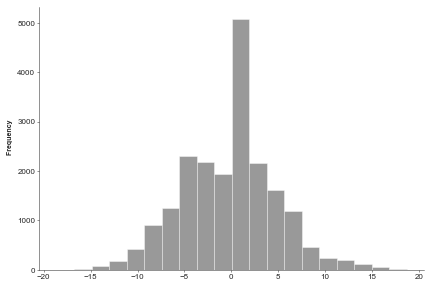

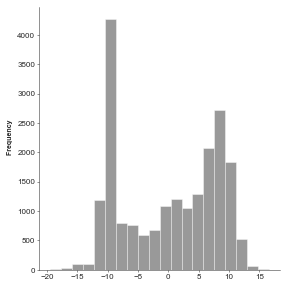

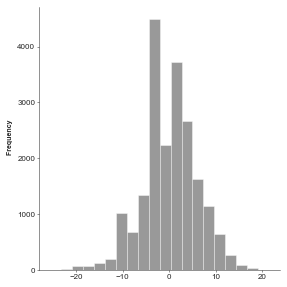

<Figure size 288x288 with 0 Axes>

In [6]:
from scivae import Vis

vis = Vis(vae, vae.u, None)
vis.plot_node_hists(show_plt=True, save_fig=False)

## Quality control 2: Visualise the correlation between features.

Since the VAE isn't magic, just good at learning correlations/patterns between input features, it's sensible 
to check that the correlations between features and nodes exists.

1 forebrain 10.5-days  H3K27ac 0.27451211178046825 0.0
1 forebrain 10.5-days  H3K27me3 -0.402467531879989 0.0
1 forebrain 10.5-days  H3K36me3 0.5516465262414582 0.0
1 forebrain 10.5-days  H3K4me1 0.06020818668346319 7.517398336563563e-18
1 forebrain 10.5-days  H3K4me3 0.2151110226888636 3.642170339777309e-212
1 forebrain 10.5-days  H3K9me3 -0.5970354897243267 0.0
1 forebrain 13.5-days  H3K36me3 0.5395661305644748 0.0
1 forebrain 16.5-days  H3K9ac 0.19928019963557014 9.06405834281384e-182
1 hindbrain 10.5-days  H3K27ac 0.26466067570234214 0.0
1 hindbrain 10.5-days  H3K27me3 -0.3883370301659645 0.0
1 hindbrain 10.5-days  H3K36me3 0.5505093325342357 0.0
1 hindbrain 10.5-days  H3K4me1 0.10958058786210036 1.5714849471693674e-55
1 hindbrain 10.5-days  H3K4me3 0.26102691177681986 0.0
1 hindbrain 10.5-days  H3K9me3 -0.6017030176265121 0.0
1 hindbrain 16.5-days  H3K36me3 0.44189516126351736 0.0
1 midbrain 10.5-days  H3K27ac 0.27449010018089043 0.0
1 midbrain 10.5-days  H3K27me3 -0.3946690236911

<Figure size 288x288 with 0 Axes>

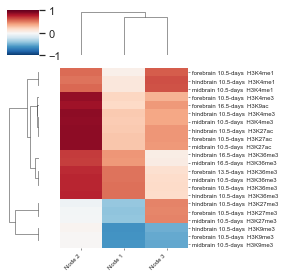

,Node 1,Node 1 padj,Node 2,Node 2 padj,Node 3,Node 3 padj,labels
0,0.274512,0.0,0.891349,0.000,0.439339,0.0,forebrain 10.5-days H3K27ac
1,-0.402468,0.0,-0.025752,0.000,0.491696,0.0,forebrain 10.5-days H3K27me3
2,0.551647,0.0,0.763373,0.000,0.188527,0.0,forebrain 10.5-days H3K36me3
3,0.060208,0.0,0.570180,0.000,0.603079,0.0,forebrain 10.5-days H3K4me1
4,0.215111,0.0,0.875666,0.000,0.351103,0.0,forebrain 10.5-days H3K4me3
5,-0.597035,0.0,0.010869,0.121,-0.508184,0.0,forebrain 10.5-days H3K9me3
6,0.539566,0.0,0.749059,0.000,0.160446,0.0,forebrain 13.5-days H3K36me3
7,0.199280,0.0,0.849864,0.000,0.433749,0.0,forebrain 16.5-days H3K9ac
8,0.264661,0.0,0.891405,0.000,0.443636,0.0,hindbrain 10.5-days H3K27ac
9,-0.388337,0.0,-0.051035,0.000,0.495081,0.0,hindbrain 10.5-days H3K27me3


In [7]:
vis.plot_node_feature_correlation(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, save_fig=False)

## Having fun with inspecting the latent space

Now we are confident it's learnt stuff, let's look at how all our genes look on the latent space!

/Users/ariane/opt/miniconda3/envs/clean_ml/lib/python3.6/site-packages/sciviso/scatterplot.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 288x288 with 0 Axes>

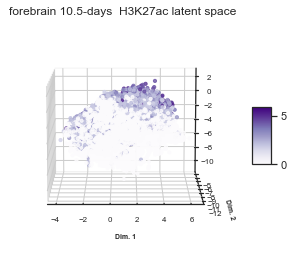

In [ ]:
vis.plot_feature_scatters(vae_df, 'external_gene_name', columns=new_cols, show_plt=True, fig_type="png", 
                          save_fig=False,
                          title="latent space")


## Plot specific genes

Since we love certain genes, lets have a look at where they are on the latent space

In [ ]:
cool_genes = [['Emx1', 'Eomes', 'Tbr1', 'Foxg1', 'Lhx6', 'Arx', 'Dlx1', 'Dlx2', 'Dlx5', 'Nr2e2', 'Otx2'],
              ['Hoxd8', 'Hoxd9', 'Hoxd10', 'Hoxd11', 'Hoxd12', 'Hoxd13', 'Hoxa7', 'Hoxa9', 'Hoxa10', 'Hoxa11',
              'Hoxa13',
              'Hoxb9', 'Hoxb13', 'Hoxc8', 'Hoxc9', 'Hoxc10', 'Hoxc11', 'Hoxc12', 'Hoxc13'],
              ['Ccna1', 'Ccna2', 'Ccnd1', 'Ccnd2', 'Ccnd3', 'Ccne1', 'Ccne2', 'Cdc25a',
               'Cdc25b', 'Cdc25c', 'E2f1', 'E2f2', 'E2f3', 'Mcm10', 'Mcm5', 'Mcm3', 'Mcm2', 'Cip2a']
              ]

vis.plot_values_on_scatters(vae_df, "external_gene_name", ['Forebrain', 'Spinal cord', 'Pro. Prolif.'],
                            cool_genes, show_plt=True, fig_type=".png",
                            save_fig=False, user_config={'s': 100})
        